In [1]:
# -*- coding: utf-8 -*-

import sys,os
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import linalg
from numpy import dot
import matplotlib
import geomloss as gs

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import grad
import torch.utils.data
import torch.backends.cudnn as cudnn
from torch.nn.modules import Linear
from torch.autograd.functional import jacobian,hessian,vjp,vhp,hvp

import random
import math

FilePath = "C:\\Users\\gaojx\\Desktop\\JumpDiffusion\\"
file_list = ['GSM1599494_ES_d0_main.csv', 'GSM1599497_ES_d2_LIFminus.csv', 'GSM1599498_ES_d4_LIFminus.csv', 'GSM1599499_ES_d7_LIFminus.csv']
table_list = []
for filein in file_list:
    table_list.append(pd.read_csv(FilePath+filein, header=None))

matrix_list = []
gene_names = table_list[0].values[:,0]


In [2]:
for table in table_list:
    matrix_list.append(table.values[:,1:].astype('float32'))

cell_counts = [matrix.shape[1] for matrix in matrix_list]

def normalize_run(mat):
    rpm = np.sum(mat,0)/1e6
    detect_pr = np.sum(mat==0,0)/float(mat.shape[0])
    return np.log(mat*(np.median(detect_pr)/detect_pr)*1.0/rpm + 1.0)

norm_mat = [normalize_run(matrix) for matrix in matrix_list]

wsub = np.array([14219,23779,6194,20332,6844,4941,4942,11403,11408,20330,20376,11272,11237,6128])-1


def nmf(X, latent_features, max_iter=100, error_limit=1e-6, fit_error_limit=1e-6, print_iter=200):
    """
    Decompose X to A*Y
    """
    eps = 1e-5
    print('Starting NMF decomposition with {} latent features and {} iterations.'.format(latent_features, max_iter))
    #X = X.toarray()   I am passing in a scipy sparse matrix

    # mask
    mask = np.sign(X)

    # initial matrices. A is random [0,1] and Y is A\X.
    rows, columns = X.shape
    A = np.random.rand(rows, latent_features)
    A = np.maximum(A, eps)

    Y = linalg.lstsq(A, X)[0]
    Y = np.maximum(Y, eps)

    masked_X = mask * X
    X_est_prev = dot(A, Y)
    for i in range(1, max_iter + 1):
        # ===== updates =====
        # Matlab: A=A.*(((W.*X)*Y')./((W.*(A*Y))*Y'));
        top = dot(masked_X, Y.T)
        bottom = (dot((mask * dot(A, Y)), Y.T)) + eps
        A *= top / bottom

        A = np.maximum(A, eps)
        # print 'A',  np.round(A, 2)

        # Matlab: Y=Y.*((A'*(W.*X))./(A'*(W.*(A*Y))));
        top = dot(A.T, masked_X)
        bottom = dot(A.T, mask * dot(A, Y)) + eps
        Y *= top / bottom
        Y = np.maximum(Y, eps)
        # print 'Y', np.round(Y, 2)


        # ==== evaluation ====
        if i % print_iter == 0 or i == 1 or i == max_iter:
            print('Iteration {}:'.format(i),)
            X_est = dot(A, Y)
            err = mask * (X_est_prev - X_est)
            fit_residual = np.sqrt(np.sum(err ** 2))
            X_est_prev = X_est

            curRes = linalg.norm(mask * (X - X_est), ord='fro')
            print('fit residual', np.round(fit_residual, 4),)
            print('total residual', np.round(curRes, 4))
            if curRes < error_limit or fit_residual < fit_error_limit:
                break
    return A, Y, dot(A,Y)

np.random.seed(0)
norm_imputed = [nmf(normin[wsub,:], latent_features = len(wsub)*4, max_iter=500)[2] for normin in norm_mat]

norm_adj = np.mean(norm_imputed[3],1)[:,np.newaxis]
subvec = np.array(list(range(14)))

#gnvec = gene_names[w_order[subvec]]

cov_mat = np.cov(norm_imputed[3][subvec,:])
whiten = np.diag(np.diag(cov_mat)**(-0.5))
unwhiten = np.diag(np.diag(cov_mat)**(0.5))

norm_imputed2 = [np.dot(whiten,(normin - norm_adj)[subvec,:]) for normin in norm_imputed]

Starting NMF decomposition with 56 latent features and 500 iterations.
Iteration 1:
fit residual 381.5832
total residual 40.9294
Iteration 200:
fit residual 40.5985
total residual 1.4135
Iteration 400:
fit residual 1.2036
total residual 0.2692
Iteration 500:
fit residual 0.1305
total residual 0.1455
Starting NMF decomposition with 56 latent features and 500 iterations.
Iteration 1:
fit residual 210.6748
total residual 14.8275
Iteration 200:
fit residual 14.8186
total residual 0.0597
Iteration 400:
fit residual 0.058
total residual 0.0019
Iteration 500:
fit residual 0.0015
total residual 0.0005
Starting NMF decomposition with 56 latent features and 500 iterations.
Iteration 1:
fit residual 395.6897
total residual 29.8804
Iteration 200:
fit residual 29.8694
total residual 0.1064
Iteration 400:
fit residual 0.0992
total residual 0.0098
Iteration 500:
fit residual 0.0061
total residual 0.0039
Starting NMF decomposition with 56 latent features and 500 iterations.
Iteration 1:
fit residual 4

In [3]:
# 多层感知机的一般类
class MLP(nn.Module):

    def __init__(self, dim_in, dim_out, dim_hidden=64, num_hidden=0, activation=nn.LeakyReLU()):
        super(MLP, self).__init__()

        if num_hidden == 0:
            self.linears = nn.ModuleList([nn.Linear(dim_in, dim_out)])
        elif num_hidden >= 1:
            self.linears = nn.ModuleList() # 需要用net.linears获取层
            self.linears.append(nn.Linear(dim_in, dim_hidden))
            self.linears.extend([nn.Linear(dim_hidden, dim_hidden) for _ in range(num_hidden-1)])
            self.linears.append(nn.Linear(dim_hidden, dim_out))
        else:
            raise Exception('number of hidden layers must be positive')

        for m in self.linears:
            #nn.init.xavier_uniform_(m.weight)
            nn.init.xavier_normal_(m.weight)
            nn.init.uniform_(m.bias,a=-0.1,b=0.1)
            #nn.init.constant_(m.bias,0) ## bias初始化为0
 
        self.activation = activation # 激活函数

    def forward(self, x):
        # 最后一层到输出层不需要激活函数
        for m in self.linears[:-1]:
            x = self.activation(m(x))
            #x = F.dropout(x,p=0.5)

        return self.linears[-1](x)


def compute_gradient_penalty(D, real_sample, fake_sample,k,p):
    real_samples = real_sample.requires_grad_(True)
    fake_samples = fake_sample.requires_grad_(True)

    real_validity = D(real_samples)
    fake_validity = D(fake_samples)

    real_grad_out = torch.ones((real_samples.shape[0],1),dtype=torch.float32,requires_grad=False,device="cuda")
    real_grad = grad(
        real_validity, real_samples, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

    fake_grad_out = torch.ones((fake_samples.shape[0],1),dtype=torch.float32,requires_grad=False,device="cuda")
    fake_grad = grad(
        fake_validity, fake_samples, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

    return (torch.sum(real_grad_norm) + torch.sum(fake_grad_norm)) * k / (real_sample.shape[0]+fake_sample.shape[0])

# 定义生成器网络
class JumpEulerForwardCuda(nn.Module):
    def __init__(self,in_features,num_hidden,dim_hidden,step_size,intensity,bd):
        super(JumpEulerForwardCuda,self).__init__()

        self.drift = MLP(in_features,in_features,dim_hidden,num_hidden)
        self.intensity = torch.tensor(intensity,device="cuda")
        self.mean = nn.Parameter(0.01*torch.ones(in_features))
        self.covHalf = nn.Parameter(0.08*torch.eye(in_features))
        self.diffusion = nn.Parameter(torch.ones(bd,in_features))
        self.in_features = in_features
        self.jump = MLP(in_features,in_features,dim_hidden,num_hidden)
        self.step_size = step_size

    def forward(self,z0,Nsim,steps):

        PopulationPath = torch.empty(size = (Nsim,steps+1,self.in_features),device="cuda")
        PopulationPath[:,0,:] = z0
        state = z0

        for i in range(1,steps+1):
            DP = D.poisson.Poisson(self.intensity*self.step_size) ## 第一次这地方忘记乘以step_size了
            pois = DP.sample((Nsim,1)).cuda()
            state = state + self.drift(state)*self.step_size + math.sqrt(self.step_size)*torch.normal(0,1,size=(Nsim,bd),device="cuda")@self.diffusion+\
                (pois*self.mean + pois**(0.5)*torch.normal(0,1,size=(Nsim,self.in_features),device="cuda")@self.covHalf)*self.jump(state)
            PopulationPath[:,i,:] = state
        return PopulationPath

# 训练参数设置

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子

a=gs.SamplesLoss(loss='sinkhorn',p=2,blur=0.01)


# 数据和模型参数
train_data = norm_imputed2

train0 = torch.tensor(train_data[0],dtype=torch.float32,requires_grad = True,device="cuda").t()
train2 = torch.tensor(train_data[1],dtype=torch.float32,requires_grad = True,device="cuda").t()
train4 = torch.tensor(train_data[2],dtype=torch.float32,requires_grad = True,device="cuda").t()
train7 = torch.tensor(train_data[3],dtype=torch.float32,requires_grad = True,device="cuda").t()


#{'intensity': 10, 'learning_rate': 0.0003, 'step_size': 0.03, 'hidden_size': 256, 'dim_hidden': 4, 'beishu': 10, 'bd': 2, 'sed': 200, 'n_critic': 3}
sed = 200
intensity = 10
lr = 0.0003
step_size = 0.03
kuan = 256
ceng = 4
bd = 2
n_critic = 3
k = 2
p = 6

n_sims = train0.shape[0]
in_features = train0.shape[1]
n_steps = [10,20,35]

setup_seed(sed)

# 创建生成器和判别器网络
netG = JumpEulerForwardCuda(in_features,ceng,kuan,step_size,intensity,bd).cuda()
netD1 = MLP(in_features,1,dim_hidden=kuan,num_hidden=ceng).cuda()
netD2 = MLP(in_features,1,dim_hidden=kuan,num_hidden=ceng).cuda()
netD3 = MLP(in_features,1,dim_hidden=kuan,num_hidden=ceng).cuda()


optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerSD1 = optim.Adam(netD1.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerSD2 = optim.Adam(netD2.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerSD3 = optim.Adam(netD3.parameters(), lr=lr, betas=(0.5, 0.999))



In [4]:
n_epochs =  30000

wd = []
for epoch in range(n_epochs):
  
    
    # -------------------
    # 训练判别器
    # -------------------
    

    # time 1

    for _ in range(n_critic):
        fake_data = netG(train0,n_sims,n_steps[2])
        fake1 = fake_data[:,n_steps[0],:]
        fake2 = fake_data[:,n_steps[1],:]
        fake3 = fake_data[:,n_steps[2],:]

        optimizerSD1.zero_grad()

        div_gp1 = compute_gradient_penalty(netD1,train2,fake1,k,p)
        d1_loss = -torch.mean(netD1(train2))+torch.mean(netD1(fake1))+div_gp1
        d1_loss.backward(retain_graph=True) # retain_graph=True

        optimizerSD1.step()

        ## 第二个D网络

        optimizerSD2.zero_grad()
        
        div_gp2 = compute_gradient_penalty(netD2,train4,fake2,k,p)
        d2_loss = -torch.mean(netD2(train4))+torch.mean(netD2(fake2))+div_gp2
        d2_loss.backward(retain_graph=True)

        optimizerSD2.step()
        
        
        optimizerSD3.zero_grad()
        
        div_gp3 = compute_gradient_penalty(netD3,train7,fake3,k,p)
        d3_loss = -torch.mean(netD3(train7))+torch.mean(netD3(fake3))+div_gp3
        d3_loss.backward(retain_graph=True)

        optimizerSD3.step()
        


    # if (epoch-2) % 5==0:

    # ----------------
    # 训练生成器,每训练3次判别器，训练一次生成器
    # ----------------

    
    for _ in range(1):
        optimizerG.zero_grad()
        fake_data = netG(train0,n_sims,n_steps[2])
        fake1 = fake_data[:,n_steps[0],:]
        fake2 = fake_data[:,n_steps[1],:]
        fake3 = fake_data[:,n_steps[2],:]
        g_loss = -torch.mean(netD1(fake1))-torch.mean(netD2(fake2))-torch.mean(netD3(fake3))
        g_loss.backward() 

        optimizerG.step()

    if epoch %10==0:
        #wd.append(a(fake_data[:,2*n_steps[0],:],train4).item())
        x1 = a(fake_data[:,n_steps[0],:],train2).item()
        x2 = a(fake_data[:,n_steps[1],:],train4).item()
        x3 = a(fake_data[:,n_steps[2],:],train7).item()
        
        wd.append(x1+x2+x3)
        
        print("training error: ",x1," and ",x2," and ",x3)
        print("total error: ",wd[-1])
        #print("epoch:",epoch,";", "d1_loss:",(-d1_loss+div_gp1).item(),";","d2_loss:",(-d2_loss+div_gp2).item(),";","g_loss:",g_loss.item())


training error:  10.80009651184082  and  27.018409729003906  and  66.88008117675781
total error:  104.69858741760254
training error:  8.881200790405273  and  13.506712913513184  and  24.130226135253906
total error:  46.51813983917236
training error:  10.395658493041992  and  10.173404693603516  and  10.742186546325684
total error:  31.31124973297119
training error:  9.807165145874023  and  8.338479995727539  and  7.475139141082764
total error:  25.620784282684326
training error:  8.457931518554688  and  7.352289199829102  and  5.781489372253418
total error:  21.591710090637207
training error:  7.290020942687988  and  6.9897141456604  and  5.124401092529297
total error:  19.404136180877686
training error:  6.264177322387695  and  6.644402503967285  and  4.537594795227051
total error:  17.44617462158203
training error:  6.219311714172363  and  6.341096878051758  and  4.6194000244140625
total error:  17.179808616638184
training error:  6.023817539215088  and  6.340810775756836  and  4.690

training error:  3.5478899478912354  and  3.1462936401367188  and  3.346609115600586
total error:  10.04079270362854
training error:  3.514224052429199  and  2.999925374984741  and  3.306670904159546
total error:  9.820820331573486
training error:  3.4751791954040527  and  3.172725200653076  and  3.201420545578003
total error:  9.849324941635132
training error:  3.414055824279785  and  2.993544101715088  and  3.1813881397247314
total error:  9.588988065719604
training error:  3.3457839488983154  and  3.132222890853882  and  3.2238845825195312
total error:  9.701891422271729
training error:  3.3558526039123535  and  2.956402063369751  and  3.2273740768432617
total error:  9.539628744125366
training error:  3.410712480545044  and  3.1087088584899902  and  3.227281093597412
total error:  9.746702432632446
training error:  3.395427703857422  and  3.144049644470215  and  3.171497344970703
total error:  9.71097469329834
training error:  3.3160629272460938  and  3.105661630630493  and  3.2449

training error:  2.876380443572998  and  3.570197105407715  and  3.0045270919799805
total error:  9.451104640960693
training error:  2.9632716178894043  and  2.6607108116149902  and  3.11564564704895
total error:  8.739628076553345
training error:  2.8396458625793457  and  2.7515482902526855  and  3.080012321472168
total error:  8.6712064743042
training error:  2.7607216835021973  and  3.114346981048584  and  3.008634090423584
total error:  8.883702754974365
training error:  2.9251227378845215  and  2.628854751586914  and  3.215470314025879
total error:  8.769447803497314
training error:  2.9296011924743652  and  3.3354997634887695  and  2.9961633682250977
total error:  9.261264324188232
training error:  2.907802104949951  and  2.646101713180542  and  2.969021797180176
total error:  8.522925615310669
training error:  2.840196371078491  and  2.7994182109832764  and  3.0146615505218506
total error:  8.654276132583618
training error:  2.848015308380127  and  2.704000473022461  and  3.0373

training error:  2.7039635181427  and  2.665541172027588  and  2.8635778427124023
total error:  8.23308253288269
training error:  2.688222885131836  and  2.4638099670410156  and  2.947053909301758
total error:  8.09908676147461
training error:  2.6610422134399414  and  2.6314055919647217  and  2.8870062828063965
total error:  8.17945408821106
training error:  2.6886701583862305  and  2.9430296421051025  and  2.8946027755737305
total error:  8.526302576065063
training error:  2.676809549331665  and  2.667146921157837  and  2.8706188201904297
total error:  8.214575290679932
training error:  2.5942044258117676  and  2.6146183013916016  and  2.8493125438690186
total error:  8.058135271072388
training error:  2.6299538612365723  and  2.5056090354919434  and  2.8080480098724365
total error:  7.943610906600952
training error:  2.6405203342437744  and  2.8117921352386475  and  2.754326343536377
total error:  8.206638813018799
training error:  2.606963634490967  and  2.558591842651367  and  2.8

training error:  2.5228042602539062  and  2.452995777130127  and  2.8245487213134766
total error:  7.80034875869751
training error:  2.456144332885742  and  2.2211155891418457  and  2.788501024246216
total error:  7.465760946273804
training error:  2.494884967803955  and  2.6854968070983887  and  2.750183582305908
total error:  7.930565357208252
training error:  2.563544511795044  and  2.517352819442749  and  2.8982858657836914
total error:  7.979183197021484
training error:  2.5232558250427246  and  2.631272315979004  and  2.792717933654785
total error:  7.947246074676514
training error:  2.4801366329193115  and  2.2888641357421875  and  2.7349791526794434
total error:  7.503979921340942
training error:  2.466352701187134  and  2.23970627784729  and  2.7988038063049316
total error:  7.5048627853393555
training error:  2.4818053245544434  and  2.2672691345214844  and  2.68147611618042
total error:  7.430550575256348
training error:  2.5072407722473145  and  2.9947755336761475  and  2.7

training error:  2.3121843338012695  and  2.398308038711548  and  2.68346905708313
total error:  7.393961429595947
training error:  2.4032018184661865  and  3.2056961059570312  and  2.6854300498962402
total error:  8.294327974319458
training error:  2.417703151702881  and  2.6931705474853516  and  2.767739772796631
total error:  7.878613471984863
training error:  2.400538921356201  and  2.504178524017334  and  2.6048145294189453
total error:  7.5095319747924805
training error:  2.3620729446411133  and  2.3849406242370605  and  2.6634445190429688
total error:  7.410458087921143
training error:  2.317152976989746  and  2.1836278438568115  and  2.729004383087158
total error:  7.229785203933716
training error:  2.3670570850372314  and  2.111614227294922  and  2.696694850921631
total error:  7.175366163253784
training error:  2.333970546722412  and  2.2763071060180664  and  2.778618335723877
total error:  7.3888959884643555
training error:  2.3687891960144043  and  2.563655138015747  and  2

training error:  2.2840819358825684  and  2.3667073249816895  and  2.6617236137390137
total error:  7.3125128746032715
training error:  2.220987558364868  and  2.6080095767974854  and  2.778550863265991
total error:  7.607547998428345
training error:  2.2255666255950928  and  2.4095993041992188  and  2.7470319271087646
total error:  7.382197856903076
training error:  2.2423346042633057  and  2.1290807723999023  and  2.6453661918640137
total error:  7.016781568527222
training error:  2.268092155456543  and  2.8673038482666016  and  2.556647300720215
total error:  7.692043304443359
training error:  2.2321112155914307  and  2.742128849029541  and  2.611746311187744
total error:  7.585986375808716
training error:  2.2180469036102295  and  2.2057719230651855  and  2.6870944499969482
total error:  7.110913276672363
training error:  2.219221830368042  and  2.0852503776550293  and  2.670412540435791
total error:  6.974884748458862
training error:  2.1991653442382812  and  2.7023918628692627  a

training error:  2.118377208709717  and  2.1628246307373047  and  2.55971360206604
total error:  6.8409154415130615
training error:  2.116213321685791  and  1.9271068572998047  and  2.487328052520752
total error:  6.530648231506348
training error:  2.0867137908935547  and  2.0034990310668945  and  2.5066585540771484
total error:  6.596871376037598
training error:  2.064406394958496  and  2.00652813911438  and  2.5825963020324707
total error:  6.653530836105347
training error:  2.1237668991088867  and  2.0662639141082764  and  2.560631513595581
total error:  6.750662326812744
training error:  2.1076817512512207  and  2.144902229309082  and  2.555180072784424
total error:  6.807764053344727
training error:  2.1168465614318848  and  1.939619779586792  and  2.529020309448242
total error:  6.585486650466919
training error:  2.184353828430176  and  2.815441608428955  and  2.54616117477417
total error:  7.545956611633301
training error:  2.1305060386657715  and  2.8822667598724365  and  2.592

training error:  1.960111379623413  and  1.9125593900680542  and  2.589536666870117
total error:  6.4622074365615845
training error:  2.0946593284606934  and  2.3932876586914062  and  2.4833221435546875
total error:  6.971269130706787
training error:  2.0082430839538574  and  2.1771469116210938  and  2.6098289489746094
total error:  6.7952189445495605
training error:  1.9761897325515747  and  2.03139591217041  and  2.6763010025024414
total error:  6.683886647224426
training error:  1.9309598207473755  and  2.0036110877990723  and  2.4094038009643555
total error:  6.343974709510803
training error:  1.981000542640686  and  1.954539179801941  and  2.6222124099731445
total error:  6.5577521324157715
training error:  1.9689663648605347  and  1.9422167539596558  and  2.4215383529663086
total error:  6.332721471786499
training error:  1.946732759475708  and  1.8839492797851562  and  2.536083221435547
total error:  6.366765260696411
training error:  2.0264406204223633  and  2.293355941772461  

training error:  1.8335652351379395  and  1.8088037967681885  and  2.3942973613739014
total error:  6.036666393280029
training error:  1.8346836566925049  and  1.8417425155639648  and  2.4534664154052734
total error:  6.129892587661743
training error:  1.807176947593689  and  1.755570650100708  and  2.3794822692871094
total error:  5.942229866981506
training error:  1.8065487146377563  and  1.7424209117889404  and  2.3530712127685547
total error:  5.9020408391952515
training error:  1.8564732074737549  and  2.3355469703674316  and  2.625253677368164
total error:  6.817273855209351
training error:  1.8173102140426636  and  1.8302849531173706  and  2.407198429107666
total error:  6.0547935962677
training error:  1.8358373641967773  and  1.8262321949005127  and  2.329730987548828
total error:  5.991800546646118
training error:  1.820108413696289  and  1.8685108423233032  and  2.4834446907043457
total error:  6.172063946723938
training error:  1.7733317613601685  and  1.7623733282089233  a

training error:  1.7002432346343994  and  2.5087461471557617  and  2.467857599258423
total error:  6.676846981048584
training error:  1.6814930438995361  and  1.751903772354126  and  2.3098936080932617
total error:  5.743290424346924
training error:  1.6640530824661255  and  1.7089152336120605  and  2.25917911529541
total error:  5.632147431373596
training error:  1.6613482236862183  and  1.7635486125946045  and  2.2654619216918945
total error:  5.690358757972717
training error:  1.6776294708251953  and  1.8535146713256836  and  2.330045700073242
total error:  5.861189842224121
training error:  1.6558802127838135  and  1.7325990200042725  and  2.40120267868042
total error:  5.789681911468506
training error:  1.6836334466934204  and  1.833247423171997  and  2.400723934173584
total error:  5.9176048040390015
training error:  1.644128680229187  and  1.722902774810791  and  2.37015962600708
total error:  5.737191081047058
training error:  1.6995372772216797  and  1.7104723453521729  and  2

training error:  1.5394306182861328  and  2.0979232788085938  and  2.342214584350586
total error:  5.9795684814453125
training error:  1.5882301330566406  and  1.7370147705078125  and  2.395005464553833
total error:  5.720250368118286
training error:  1.5527880191802979  and  1.755145788192749  and  2.329738140106201
total error:  5.637671947479248
training error:  1.5248174667358398  and  1.938870906829834  and  2.2517197132110596
total error:  5.715408086776733
training error:  1.5300774574279785  and  1.5992543697357178  and  2.2436323165893555
total error:  5.372964143753052
training error:  1.628239393234253  and  1.775918960571289  and  2.487748146057129
total error:  5.891906499862671
training error:  1.6375281810760498  and  1.8841131925582886  and  2.375051498413086
total error:  5.896692872047424
training error:  1.5860495567321777  and  1.6962296962738037  and  2.3860955238342285
total error:  5.66837477684021
training error:  1.524288296699524  and  1.7443276643753052  and 

training error:  1.4324554204940796  and  1.6538453102111816  and  2.192025899887085
total error:  5.278326630592346
training error:  1.4310113191604614  and  1.634415626525879  and  2.223324775695801
total error:  5.288751721382141
training error:  1.3865429162979126  and  1.6578224897384644  and  2.2503767013549805
total error:  5.294742107391357
training error:  1.3965177536010742  and  1.5929687023162842  and  2.1573619842529297
total error:  5.146848440170288
training error:  1.4264315366744995  and  1.6098270416259766  and  2.22286319732666
total error:  5.259121775627136
training error:  1.4090521335601807  and  1.886955976486206  and  2.460176706314087
total error:  5.756184816360474
training error:  1.4039705991744995  and  1.7757158279418945  and  2.2913804054260254
total error:  5.471066832542419
training error:  1.3962987661361694  and  1.6256892681121826  and  2.3499550819396973
total error:  5.371943116188049
training error:  1.377759575843811  and  1.6144942045211792  an

training error:  1.276810884475708  and  1.7135865688323975  and  2.167935848236084
total error:  5.1583333015441895
training error:  1.2809431552886963  and  2.065255641937256  and  2.27921724319458
total error:  5.625416040420532
training error:  1.2390559911727905  and  1.5040664672851562  and  2.1386842727661133
total error:  4.88180673122406
training error:  1.32861328125  and  1.5387721061706543  and  2.245896816253662
total error:  5.113282203674316
training error:  1.264432430267334  and  1.656229019165039  and  2.126375675201416
total error:  5.047037124633789
training error:  1.2943519353866577  and  1.4903614521026611  and  2.0973310470581055
total error:  4.882044434547424
training error:  1.2697453498840332  and  1.6149895191192627  and  2.4750990867614746
total error:  5.3598339557647705
training error:  1.2631936073303223  and  1.6226332187652588  and  2.159884214401245
total error:  5.045711040496826
training error:  1.270054817199707  and  1.4678611755371094  and  2.14

training error:  1.1750019788742065  and  1.529849886894226  and  2.088331699371338
total error:  4.7931835651397705
training error:  1.158911108970642  and  1.5125703811645508  and  2.1423778533935547
total error:  4.813859343528748
training error:  1.2073442935943604  and  1.652349591255188  and  2.1492857933044434
total error:  5.008979678153992
training error:  1.171128511428833  and  1.4283541440963745  and  2.089221954345703
total error:  4.688704609870911
training error:  1.1450952291488647  and  1.3659541606903076  and  2.0575919151306152
total error:  4.568641304969788
training error:  1.152580976486206  and  1.3979895114898682  and  2.05171537399292
total error:  4.602285861968994
training error:  1.1538903713226318  and  1.4717206954956055  and  2.006335735321045
total error:  4.631946802139282
training error:  1.139628529548645  and  1.4577901363372803  and  2.2980024814605713
total error:  4.895421147346497
training error:  1.1209616661071777  and  1.3448739051818848  and 

training error:  1.0556727647781372  and  1.3381788730621338  and  2.0446901321411133
total error:  4.438541769981384
training error:  1.052259087562561  and  1.5232805013656616  and  2.0525104999542236
total error:  4.628050088882446
training error:  1.0659849643707275  and  1.4137225151062012  and  2.0347037315368652
total error:  4.514411211013794
training error:  1.071333646774292  and  1.3116862773895264  and  1.9415433406829834
total error:  4.324563264846802
training error:  1.0464646816253662  and  1.3973572254180908  and  2.0662078857421875
total error:  4.5100297927856445
training error:  1.053134560585022  and  1.343564510345459  and  2.011512279510498
total error:  4.408211350440979
training error:  1.015687346458435  and  1.3132655620574951  and  1.9624978303909302
total error:  4.29145073890686
training error:  1.0334973335266113  and  1.2842767238616943  and  2.01836895942688
total error:  4.3361430168151855
training error:  1.0928758382797241  and  1.3555974960327148  a

training error:  0.9919678568840027  and  1.271418809890747  and  2.019733428955078
total error:  4.283120095729828
training error:  0.9768972992897034  and  1.3832863569259644  and  2.0091683864593506
total error:  4.369352042675018
training error:  0.9557905793190002  and  1.2440747022628784  and  1.9203944206237793
total error:  4.120259702205658
training error:  0.9837448596954346  and  1.3158464431762695  and  2.0394351482391357
total error:  4.33902645111084
training error:  0.9851474761962891  and  1.4408156871795654  and  2.0324361324310303
total error:  4.458399295806885
training error:  0.971053421497345  and  1.2889642715454102  and  1.9288420677185059
total error:  4.188859760761261
training error:  0.9752647280693054  and  1.3179935216903687  and  1.9109687805175781
total error:  4.204227030277252
training error:  1.0028456449508667  and  1.3230713605880737  and  1.9716663360595703
total error:  4.297583341598511
training error:  0.9717896580696106  and  1.289711594581604 

training error:  1.0354583263397217  and  1.4197041988372803  and  2.0284931659698486
total error:  4.483655691146851
training error:  0.9643580913543701  and  1.2713425159454346  and  1.867785930633545
total error:  4.10348653793335
training error:  0.9309660196304321  and  1.4360313415527344  and  1.8864641189575195
total error:  4.253461480140686
training error:  0.9415208101272583  and  1.4736781120300293  and  1.9736337661743164
total error:  4.388832688331604
training error:  0.893945574760437  and  1.2155733108520508  and  1.900944471359253
total error:  4.010463356971741
training error:  0.8977881669998169  and  1.2235825061798096  and  1.893587589263916
total error:  4.0149582624435425
training error:  0.8873767852783203  and  1.223015546798706  and  1.888223648071289
total error:  3.9986159801483154
training error:  0.9109485149383545  and  1.2134203910827637  and  1.851811408996582
total error:  3.9761803150177
training error:  0.9208765029907227  and  1.3616738319396973  an

training error:  0.8418809771537781  and  1.1559945344924927  and  1.7912344932556152
total error:  3.789110004901886
training error:  0.8370885848999023  and  1.1364264488220215  and  1.8341426849365234
total error:  3.8076577186584473
training error:  0.8571903705596924  and  1.2631921768188477  and  1.85010826587677
total error:  3.97049081325531
training error:  0.8178703784942627  and  1.1456962823867798  and  1.7664587497711182
total error:  3.7300254106521606
training error:  0.8530040979385376  and  1.2383509874343872  and  1.8425705432891846
total error:  3.9339256286621094
training error:  0.8491373062133789  and  1.2140755653381348  and  1.9551472663879395
total error:  4.018360137939453
training error:  0.8293858766555786  and  1.1438276767730713  and  1.7430343627929688
total error:  3.7162479162216187
training error:  0.8468134999275208  and  1.1365926265716553  and  1.8250830173492432
total error:  3.808489143848419
training error:  0.8665604591369629  and  1.13090872764

training error:  0.8075998425483704  and  1.1719233989715576  and  1.8429325819015503
total error:  3.8224558234214783
training error:  0.7992228269577026  and  1.1452512741088867  and  1.7639315128326416
total error:  3.708405613899231
training error:  0.7564411759376526  and  1.06585693359375  and  1.7425838708877563
total error:  3.564881980419159
training error:  0.7902550101280212  and  1.1501375436782837  and  1.733169436454773
total error:  3.673561990261078
training error:  0.7846952676773071  and  1.0688220262527466  and  1.773935317993164
total error:  3.6274526119232178
training error:  0.7974464893341064  and  1.1691077947616577  and  1.8594186305999756
total error:  3.8259729146957397
training error:  0.7956670522689819  and  1.1418721675872803  and  1.851722002029419
total error:  3.789261221885681
training error:  0.8020001649856567  and  1.268189787864685  and  1.7967214584350586
total error:  3.8669114112854004
training error:  0.7886043787002563  and  1.10925173759460

training error:  0.7640377283096313  and  1.1176308393478394  and  1.7595800161361694
total error:  3.64124858379364
training error:  0.7652072310447693  and  1.1057565212249756  and  1.7492811679840088
total error:  3.6202449202537537
training error:  0.7536868453025818  and  1.2023255825042725  and  1.7529187202453613
total error:  3.7089311480522156
training error:  0.7833783030509949  and  1.1067403554916382  and  1.7368216514587402
total error:  3.6269403100013733
training error:  0.7759652137756348  and  1.1411519050598145  and  1.7830851078033447
total error:  3.700202226638794
training error:  0.7839905619621277  and  1.2014219760894775  and  1.7347767353057861
total error:  3.7201892733573914
training error:  0.7949304580688477  and  1.1578433513641357  and  1.828634262084961
total error:  3.7814080715179443
training error:  0.7790411114692688  and  1.1193692684173584  and  1.7668116092681885
total error:  3.6652219891548157
training error:  0.7547497153282166  and  1.09689569

training error:  0.6859874725341797  and  1.0465185642242432  and  1.6861364841461182
total error:  3.418642520904541
training error:  0.7149262428283691  and  1.0994691848754883  and  1.732783555984497
total error:  3.5471789836883545
training error:  0.6873631477355957  and  0.9861160516738892  and  1.7035603523254395
total error:  3.3770395517349243
training error:  0.691083550453186  and  1.102242350578308  and  1.7395882606506348
total error:  3.532914161682129
training error:  0.7624099254608154  and  1.3112788200378418  and  1.813778042793274
total error:  3.887466788291931
training error:  0.6994438171386719  and  1.1123647689819336  and  1.7856197357177734
total error:  3.597428321838379
training error:  0.7154181003570557  and  1.0720181465148926  and  1.700139045715332
total error:  3.4875752925872803
training error:  0.691234827041626  and  1.315537929534912  and  1.8262507915496826
total error:  3.8330235481262207
training error:  0.6829757690429688  and  1.113576173782348

training error:  0.7080176472663879  and  1.1780219078063965  and  1.733311414718628
total error:  3.6193509697914124
training error:  0.6690926551818848  and  1.034975290298462  and  1.621544361114502
total error:  3.3256123065948486
training error:  0.648126482963562  and  1.0901658535003662  and  1.6423897743225098
total error:  3.380682110786438
training error:  0.6835728287696838  and  1.2634494304656982  and  2.0080149173736572
total error:  3.9550371766090393
training error:  1.005528450012207  and  2.387354850769043  and  2.3702406883239746
total error:  5.763123989105225
training error:  0.6737105250358582  and  1.0045729875564575  and  1.7078890800476074
total error:  3.386172592639923
training error:  0.6834622025489807  and  0.9928630590438843  and  1.6808123588562012
total error:  3.357137620449066
training error:  0.6777844429016113  and  1.0537092685699463  and  1.7250301837921143
total error:  3.456523895263672
training error:  0.7592671513557434  and  1.164948940277099

training error:  0.6034497618675232  and  0.9884207844734192  and  1.583742380142212
total error:  3.1756129264831543
training error:  0.630908727645874  and  1.2536096572875977  and  1.7495102882385254
total error:  3.634028673171997
training error:  0.6360573768615723  and  1.034749150276184  and  1.6740736961364746
total error:  3.344880223274231
training error:  0.7183074951171875  and  1.133015513420105  and  1.7269196510314941
total error:  3.5782426595687866
training error:  0.6551021337509155  and  1.0611627101898193  and  1.6736481189727783
total error:  3.389912962913513
training error:  0.6495977640151978  and  1.1209964752197266  and  1.7359910011291504
total error:  3.5065852403640747
training error:  0.6759804487228394  and  1.1783473491668701  and  1.7524018287658691
total error:  3.6067296266555786
training error:  0.6219696998596191  and  1.0299640893936157  and  1.5962862968444824
total error:  3.2482200860977173
training error:  0.6892059445381165  and  1.15199124813

training error:  0.6380215883255005  and  1.0601648092269897  and  1.7771358489990234
total error:  3.4753222465515137
training error:  0.6292997598648071  and  1.1446839570999146  and  1.6731555461883545
total error:  3.447139263153076
training error:  0.590997040271759  and  0.9704791903495789  and  1.6899690628051758
total error:  3.2514452934265137
training error:  0.6315608620643616  and  1.1009190082550049  and  1.7448527812957764
total error:  3.477332651615143
training error:  0.6360399723052979  and  1.1232070922851562  and  1.7075275182724
total error:  3.466774582862854
training error:  0.6425351500511169  and  1.0467931032180786  and  1.6647164821624756
total error:  3.354044735431671
training error:  0.6628471612930298  and  1.1750152111053467  and  1.782938838005066
total error:  3.6208012104034424
training error:  0.6165822744369507  and  1.1050516366958618  and  1.6891506910324097
total error:  3.410784602165222
training error:  0.6214428544044495  and  1.12535274028778

training error:  0.5745933651924133  and  1.0411100387573242  and  1.575932502746582
total error:  3.1916359066963196
training error:  0.5570099949836731  and  0.9387466907501221  and  1.5497195720672607
total error:  3.045476257801056
training error:  0.5849295854568481  and  1.0358366966247559  and  1.5936728715896606
total error:  3.2144391536712646
training error:  0.5814434885978699  and  0.9580181241035461  and  1.6251466274261475
total error:  3.1646082401275635
training error:  0.5789204239845276  and  1.0062369108200073  and  1.6338067054748535
total error:  3.2189640402793884
training error:  0.5691754817962646  and  0.9623252749443054  and  1.6254050731658936
total error:  3.1569058299064636
training error:  0.5469556450843811  and  0.9490927457809448  and  1.5887422561645508
total error:  3.0847906470298767
training error:  0.572035014629364  and  0.9442411661148071  and  1.6566505432128906
total error:  3.1729267239570618
training error:  0.6057723760604858  and  0.9825513

training error:  0.5492238998413086  and  1.073095440864563  and  1.666084885597229
total error:  3.2884042263031006
training error:  0.5659011006355286  and  0.9650295972824097  and  1.5983295440673828
total error:  3.129260241985321
training error:  0.545743465423584  and  0.9316229820251465  and  1.539383888244629
total error:  3.0167503356933594
training error:  0.653626561164856  and  1.074120283126831  and  1.6413257122039795
total error:  3.3690725564956665
training error:  0.5833179950714111  and  0.9647365212440491  and  1.5817753076553345
total error:  3.1298298239707947
training error:  0.5314140319824219  and  0.9804848432540894  and  1.5946907997131348
total error:  3.106589674949646
training error:  0.6030430793762207  and  1.0672051906585693  and  1.6250531673431396
total error:  3.2953014373779297
training error:  0.6130378246307373  and  1.0650328397750854  and  1.6600310802459717
total error:  3.3381017446517944
training error:  0.5656463503837585  and  0.963785767555

training error:  0.5328067541122437  and  0.9196313619613647  and  1.583728313446045
total error:  3.0361664295196533
training error:  0.5641523599624634  and  1.068885087966919  and  1.6565306186676025
total error:  3.289568066596985
training error:  0.5419087409973145  and  1.1597625017166138  and  1.705460786819458
total error:  3.4071320295333862
training error:  0.5246741771697998  and  0.9336543083190918  and  1.5507686138153076
total error:  3.009097099304199
training error:  0.5603631734848022  and  1.2203112840652466  and  1.617255449295044
total error:  3.3979299068450928
training error:  0.5437086820602417  and  0.9462416172027588  and  1.6229536533355713
total error:  3.1129039525985718
training error:  0.5390185117721558  and  0.9525393843650818  and  1.5757988691329956
total error:  3.067356765270233
training error:  0.5565402507781982  and  1.1332361698150635  and  1.5656862258911133
total error:  3.255462646484375
training error:  0.5345320105552673  and  0.925509095191

training error:  0.5137012004852295  and  0.9738060832023621  and  1.5957276821136475
total error:  3.083234965801239
training error:  0.5246144533157349  and  1.071692943572998  and  1.6272685527801514
total error:  3.2235759496688843
training error:  0.5197619199752808  and  0.9409661293029785  and  1.5679597854614258
total error:  3.028687834739685
training error:  0.6331663131713867  and  1.142460584640503  and  1.7212553024291992
total error:  3.496882200241089
training error:  0.5656967163085938  and  1.0143967866897583  and  1.6157360076904297
total error:  3.1958295106887817
training error:  0.5661277174949646  and  1.0276904106140137  and  1.6401715278625488
total error:  3.233989655971527
training error:  0.5445732474327087  and  1.0811967849731445  and  1.6394648551940918
total error:  3.265234887599945
training error:  0.5218128561973572  and  0.9718798398971558  and  1.5755279064178467
total error:  3.0692206025123596
training error:  0.5234749913215637  and  0.94036823511

training error:  0.49605464935302734  and  0.9193143248558044  and  1.5493425130844116
total error:  2.9647114872932434
training error:  0.5189452171325684  and  1.0786559581756592  and  1.6421563625335693
total error:  3.239757537841797
training error:  0.4960876703262329  and  0.8703572750091553  and  1.4828587770462036
total error:  2.849303722381592
training error:  0.5290657877922058  and  1.014366626739502  and  1.5679980516433716
total error:  3.1114304661750793
training error:  0.4923883080482483  and  0.921485960483551  and  1.5598258972167969
total error:  2.973700165748596
training error:  0.490418016910553  and  0.9169602990150452  and  1.5040960311889648
total error:  2.911474347114563
training error:  0.5067246556282043  and  0.9873771667480469  and  1.546234130859375
total error:  3.040335953235626
training error:  0.5061086416244507  and  1.0284392833709717  and  1.5882959365844727
total error:  3.122843861579895
training error:  0.5365338325500488  and  0.9802706837654

training error:  0.57033371925354  and  1.0745418071746826  and  1.6337311267852783
total error:  3.278606653213501
training error:  0.5146433711051941  and  0.9625681042671204  and  1.5530924797058105
total error:  3.030303955078125
training error:  0.5062142610549927  and  0.9372563362121582  and  1.5576610565185547
total error:  3.0011316537857056
training error:  0.4946022033691406  and  0.9566919207572937  and  1.5576080083847046
total error:  3.008902132511139
training error:  0.4843440651893616  and  0.8915885090827942  and  1.4705829620361328
total error:  2.8465155363082886
training error:  0.5043601393699646  and  0.9655399322509766  and  1.4811464548110962
total error:  2.9510465264320374
training error:  0.47969740629196167  and  0.8714747428894043  and  1.4640464782714844
total error:  2.8152186274528503
training error:  0.46352553367614746  and  0.8616369366645813  and  1.4711031913757324
total error:  2.796265661716461
training error:  0.49348607659339905  and  0.9704347

training error:  0.46890494227409363  and  0.9295079112052917  and  1.5236363410949707
total error:  2.922049194574356
training error:  0.4630005359649658  and  0.9101518988609314  and  1.531868577003479
total error:  2.905021011829376
training error:  0.44824910163879395  and  0.8777178525924683  and  1.5639564990997314
total error:  2.8899234533309937
training error:  0.5054076910018921  and  1.044612169265747  and  1.5248152017593384
total error:  3.0748350620269775
training error:  0.4714117646217346  and  0.9943460822105408  and  1.5216748714447021
total error:  2.9874327182769775
training error:  0.4600370526313782  and  0.873610258102417  and  1.4315910339355469
total error:  2.765238344669342
training error:  0.47633397579193115  and  0.9608265161514282  and  1.5276849269866943
total error:  2.9648454189300537
training error:  0.5066203474998474  and  0.9445830583572388  and  1.535370111465454
total error:  2.9865735173225403
training error:  0.615190863609314  and  1.176569700

training error:  0.4607127606868744  and  0.9413170218467712  and  1.4947996139526367
total error:  2.8968293964862823
training error:  0.4522649049758911  and  0.8475474119186401  and  1.388429880142212
total error:  2.688242197036743
training error:  0.48589587211608887  and  1.0034675598144531  and  1.5207104682922363
total error:  3.0100739002227783
training error:  0.4930654466152191  and  0.9292794466018677  and  1.5012528896331787
total error:  2.9235977828502655
training error:  0.4774925112724304  and  0.9594985842704773  and  1.5127956867218018
total error:  2.9497867822647095
training error:  0.4858693778514862  and  1.0400347709655762  and  1.6233925819396973
total error:  3.1492967307567596
training error:  0.4557303786277771  and  0.9092516899108887  and  1.473823070526123
total error:  2.838805139064789
training error:  0.49080926179885864  and  0.8896142840385437  and  1.52158522605896
total error:  2.9020087718963623
training error:  0.46284085512161255  and  0.9209805

training error:  0.4598035514354706  and  0.8566054105758667  and  1.4696481227874756
total error:  2.786057084798813
training error:  0.4465791583061218  and  0.863747239112854  and  1.4896371364593506
total error:  2.7999635338783264
training error:  0.4812106490135193  and  0.8858506679534912  and  1.491546630859375
total error:  2.8586079478263855
training error:  0.4772377610206604  and  0.8929922580718994  and  1.5344064235687256
total error:  2.9046364426612854
training error:  0.4375186562538147  and  0.8825024366378784  and  1.4644957780838013
total error:  2.7845168709754944
training error:  0.5228910446166992  and  1.1655055284500122  and  1.574853539466858
total error:  3.2632501125335693
training error:  0.4581131041049957  and  0.9057556986808777  and  1.532718300819397
total error:  2.8965871036052704
training error:  0.4636180102825165  and  0.8492732048034668  and  1.4489115476608276
total error:  2.761802762746811
training error:  0.4656594693660736  and  1.0102965831

training error:  0.46233323216438293  and  0.9639483690261841  and  1.545398235321045
total error:  2.971679836511612
training error:  0.4381195604801178  and  0.8979685306549072  and  1.4183881282806396
total error:  2.7544762194156647
training error:  0.45422258973121643  and  0.8992581367492676  and  1.467531681060791
total error:  2.821012407541275
training error:  0.4887593984603882  and  0.976581871509552  and  1.5288009643554688
total error:  2.994142234325409
training error:  0.4921281933784485  and  0.9772821068763733  and  1.4846947193145752
total error:  2.954105019569397
training error:  0.44605398178100586  and  0.8520104885101318  and  1.5411206483840942
total error:  2.839185118675232
training error:  0.4208921492099762  and  0.8371128439903259  and  1.3943250179290771
total error:  2.6523300111293793
training error:  0.4393863379955292  and  0.8623030781745911  and  1.4278960227966309
total error:  2.729585438966751
training error:  0.44762343168258667  and  0.997642040

training error:  0.4112042486667633  and  0.9654936790466309  and  1.4067983627319336
total error:  2.7834962904453278
training error:  0.4359343945980072  and  0.9347893595695496  and  1.5860868692398071
total error:  2.956810623407364
training error:  0.45214200019836426  and  0.9131580591201782  and  1.484306812286377
total error:  2.8496068716049194
training error:  0.4099404811859131  and  0.8534600734710693  and  1.4659700393676758
total error:  2.729370594024658
training error:  0.4301919937133789  and  0.8425558805465698  and  1.3992290496826172
total error:  2.671976923942566
training error:  0.45707738399505615  and  0.9225061535835266  and  1.5515774488449097
total error:  2.9311609864234924
training error:  0.42109519243240356  and  0.838612973690033  and  1.4401700496673584
total error:  2.699878215789795
training error:  0.4071996808052063  and  0.8620234727859497  and  1.456252098083496
total error:  2.725475251674652
training error:  0.43674176931381226  and  0.90257942

training error:  0.436023473739624  and  0.885948657989502  and  1.4631879329681396
total error:  2.7851600646972656
training error:  0.4164940118789673  and  0.8489035367965698  and  1.4480743408203125
total error:  2.7134718894958496
training error:  0.45165300369262695  and  0.8944259285926819  and  1.4838738441467285
total error:  2.8299527764320374
training error:  0.45891517400741577  and  0.9424208402633667  and  1.4518481492996216
total error:  2.853184163570404
training error:  0.43951866030693054  and  0.9468902349472046  and  1.5936286449432373
total error:  2.9800375401973724
training error:  0.4373362362384796  and  0.9099841117858887  and  1.4495067596435547
total error:  2.796827107667923
training error:  0.4185383915901184  and  0.8486212491989136  and  1.4208389520645142
total error:  2.687998592853546
training error:  0.4253025949001312  and  0.9390225410461426  and  1.4375615119934082
total error:  2.801886647939682
training error:  0.4447084665298462  and  0.8573709

training error:  0.37925106287002563  and  0.836087703704834  and  1.3419256210327148
total error:  2.5572643876075745
training error:  0.3775075674057007  and  0.7508388757705688  and  1.3251012563705444
total error:  2.453447699546814
training error:  0.39927753806114197  and  0.8358978629112244  and  1.4250328540802002
total error:  2.6602082550525665
training error:  0.39094042778015137  and  0.814808189868927  and  1.452836513519287
total error:  2.6585851311683655
training error:  0.3760465085506439  and  0.8092726469039917  and  1.3704913854599
total error:  2.5558105409145355
training error:  0.38773801922798157  and  0.816326916217804  and  1.4357969760894775
total error:  2.639861911535263
training error:  0.5089238882064819  and  1.1235566139221191  and  1.5911076068878174
total error:  3.2235881090164185
training error:  0.4476906359195709  and  0.996640145778656  and  1.4744192361831665
total error:  2.9187500178813934
training error:  0.3833410143852234  and  0.8243888020

training error:  0.3989662230014801  and  0.8673915863037109  and  1.5010099411010742
total error:  2.7673677504062653
training error:  0.3789576292037964  and  0.8185292482376099  and  1.394423484802246
total error:  2.5919103622436523
training error:  0.3997039198875427  and  0.870741605758667  and  1.431349277496338
total error:  2.7017948031425476
training error:  0.37449321150779724  and  0.8331968188285828  and  1.3445382118225098
total error:  2.5522282421588898
training error:  0.40140098333358765  and  0.929729700088501  and  1.4203248023986816
total error:  2.7514554858207703
training error:  0.3740176558494568  and  0.7910350561141968  and  1.3547521829605103
total error:  2.519804894924164
training error:  0.4117021858692169  and  0.8207128047943115  and  1.3872413635253906
total error:  2.619656354188919
training error:  0.4114311933517456  and  0.931978166103363  and  1.4035677909851074
total error:  2.746977150440216
training error:  0.4402880072593689  and  0.9946020841

training error:  0.37505200505256653  and  0.7923526763916016  and  1.3377292156219482
total error:  2.5051338970661163
training error:  0.385822057723999  and  0.8826221227645874  and  1.4126508235931396
total error:  2.681095004081726
training error:  0.3865869343280792  and  0.8321449756622314  and  1.381908893585205
total error:  2.6006408035755157
training error:  0.40127116441726685  and  0.8687952160835266  and  1.419231653213501
total error:  2.6892980337142944
training error:  0.44504570960998535  and  0.9324996471405029  and  1.5539950132369995
total error:  2.931540369987488
training error:  0.4024665355682373  and  0.9092708826065063  and  1.4347751140594482
total error:  2.746512532234192
training error:  0.4728330373764038  and  1.1896450519561768  and  1.610865831375122
total error:  3.2733439207077026
training error:  0.44790327548980713  and  0.9346819519996643  and  1.4423691034317017
total error:  2.824954330921173
training error:  0.40948382019996643  and  0.8996103

training error:  0.4018665850162506  and  0.8457108736038208  and  1.408523678779602
total error:  2.6561011373996735
training error:  0.3907531499862671  and  0.8963568210601807  and  1.4249812364578247
total error:  2.7120912075042725
training error:  0.3945639133453369  and  0.8633887767791748  and  1.3890515565872192
total error:  2.647004246711731
training error:  0.3715306520462036  and  0.819975733757019  and  1.321518898010254
total error:  2.5130252838134766
training error:  0.579950749874115  and  1.3015333414077759  and  1.8311357498168945
total error:  3.7126198410987854
training error:  0.3956696689128876  and  0.7986149787902832  and  1.3527896404266357
total error:  2.5470742881298065
training error:  0.44141197204589844  and  1.0156824588775635  and  1.4797015190124512
total error:  2.936795949935913
training error:  0.43279317021369934  and  1.0597814321517944  and  1.5749876499176025
total error:  3.0675622522830963
training error:  0.4183686375617981  and  0.90476828

training error:  0.3898855149745941  and  0.8255243301391602  and  1.3320019245147705
total error:  2.547411769628525
training error:  0.36446017026901245  and  0.8149515390396118  and  1.3432844877243042
total error:  2.5226961970329285
training error:  0.4535272717475891  and  0.9106404185295105  and  1.4272212982177734
total error:  2.791388988494873
training error:  0.3725716769695282  and  0.767959713935852  and  1.3123283386230469
total error:  2.452859729528427
training error:  0.40542733669281006  and  0.8009815216064453  and  1.3438947200775146
total error:  2.55030357837677
training error:  0.37943312525749207  and  0.7932228446006775  and  1.3244049549102783
total error:  2.497060924768448
training error:  0.3618149757385254  and  0.8142951130867004  and  1.332748293876648
total error:  2.508858382701874
training error:  0.3782857060432434  and  0.7911620736122131  and  1.3287372589111328
total error:  2.4981850385665894
training error:  0.40134313702583313  and  0.906049728

training error:  0.37458011507987976  and  0.8627586364746094  and  1.3264849185943604
total error:  2.5638236701488495
training error:  0.4835450351238251  and  0.9338767528533936  and  1.4019817113876343
total error:  2.819403499364853
training error:  0.41161346435546875  and  0.852715253829956  and  1.3536028861999512
total error:  2.617931604385376
training error:  0.39756345748901367  and  0.8946528434753418  and  1.3844637870788574
total error:  2.676680088043213
training error:  0.37227770686149597  and  0.8177505731582642  and  1.3639311790466309
total error:  2.553959459066391
training error:  0.3879605531692505  and  0.870999276638031  and  1.353568196296692
total error:  2.6125280261039734
training error:  0.36989670991897583  and  0.8810818791389465  and  1.3743659257888794
total error:  2.6253445148468018
training error:  0.35651707649230957  and  0.7753021717071533  and  1.3680894374847412
total error:  2.499908685684204
training error:  0.37084341049194336  and  0.91716

In [6]:
torch.save(netG.state_dict(),"./Gene14.pt")

In [7]:
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

setup_seed(435)

path = netG(train0,train0.shape[0],35)
G2 = path[:,10,:]
G4 = path[:,20,:]
G7 = path[:,35,:]

print(a(G2,train2),a(G4,train4),a(G7,train7))

T0 = train0.detach().cpu().numpy()
T2 = train2.detach().cpu().numpy()
T4 = train4.detach().cpu().numpy()
T7 = train7.detach().cpu().numpy()

G2 = G2.detach().cpu().numpy()
G4 = G4.detach().cpu().numpy()
G7 = G7.detach().cpu().numpy()


tensor(0.3433, device='cuda:0', grad_fn=<SelectBackward>) tensor(0.7688, device='cuda:0', grad_fn=<SelectBackward>) tensor(1.3249, device='cuda:0', grad_fn=<SelectBackward>)


No handles with labels found to put in legend.


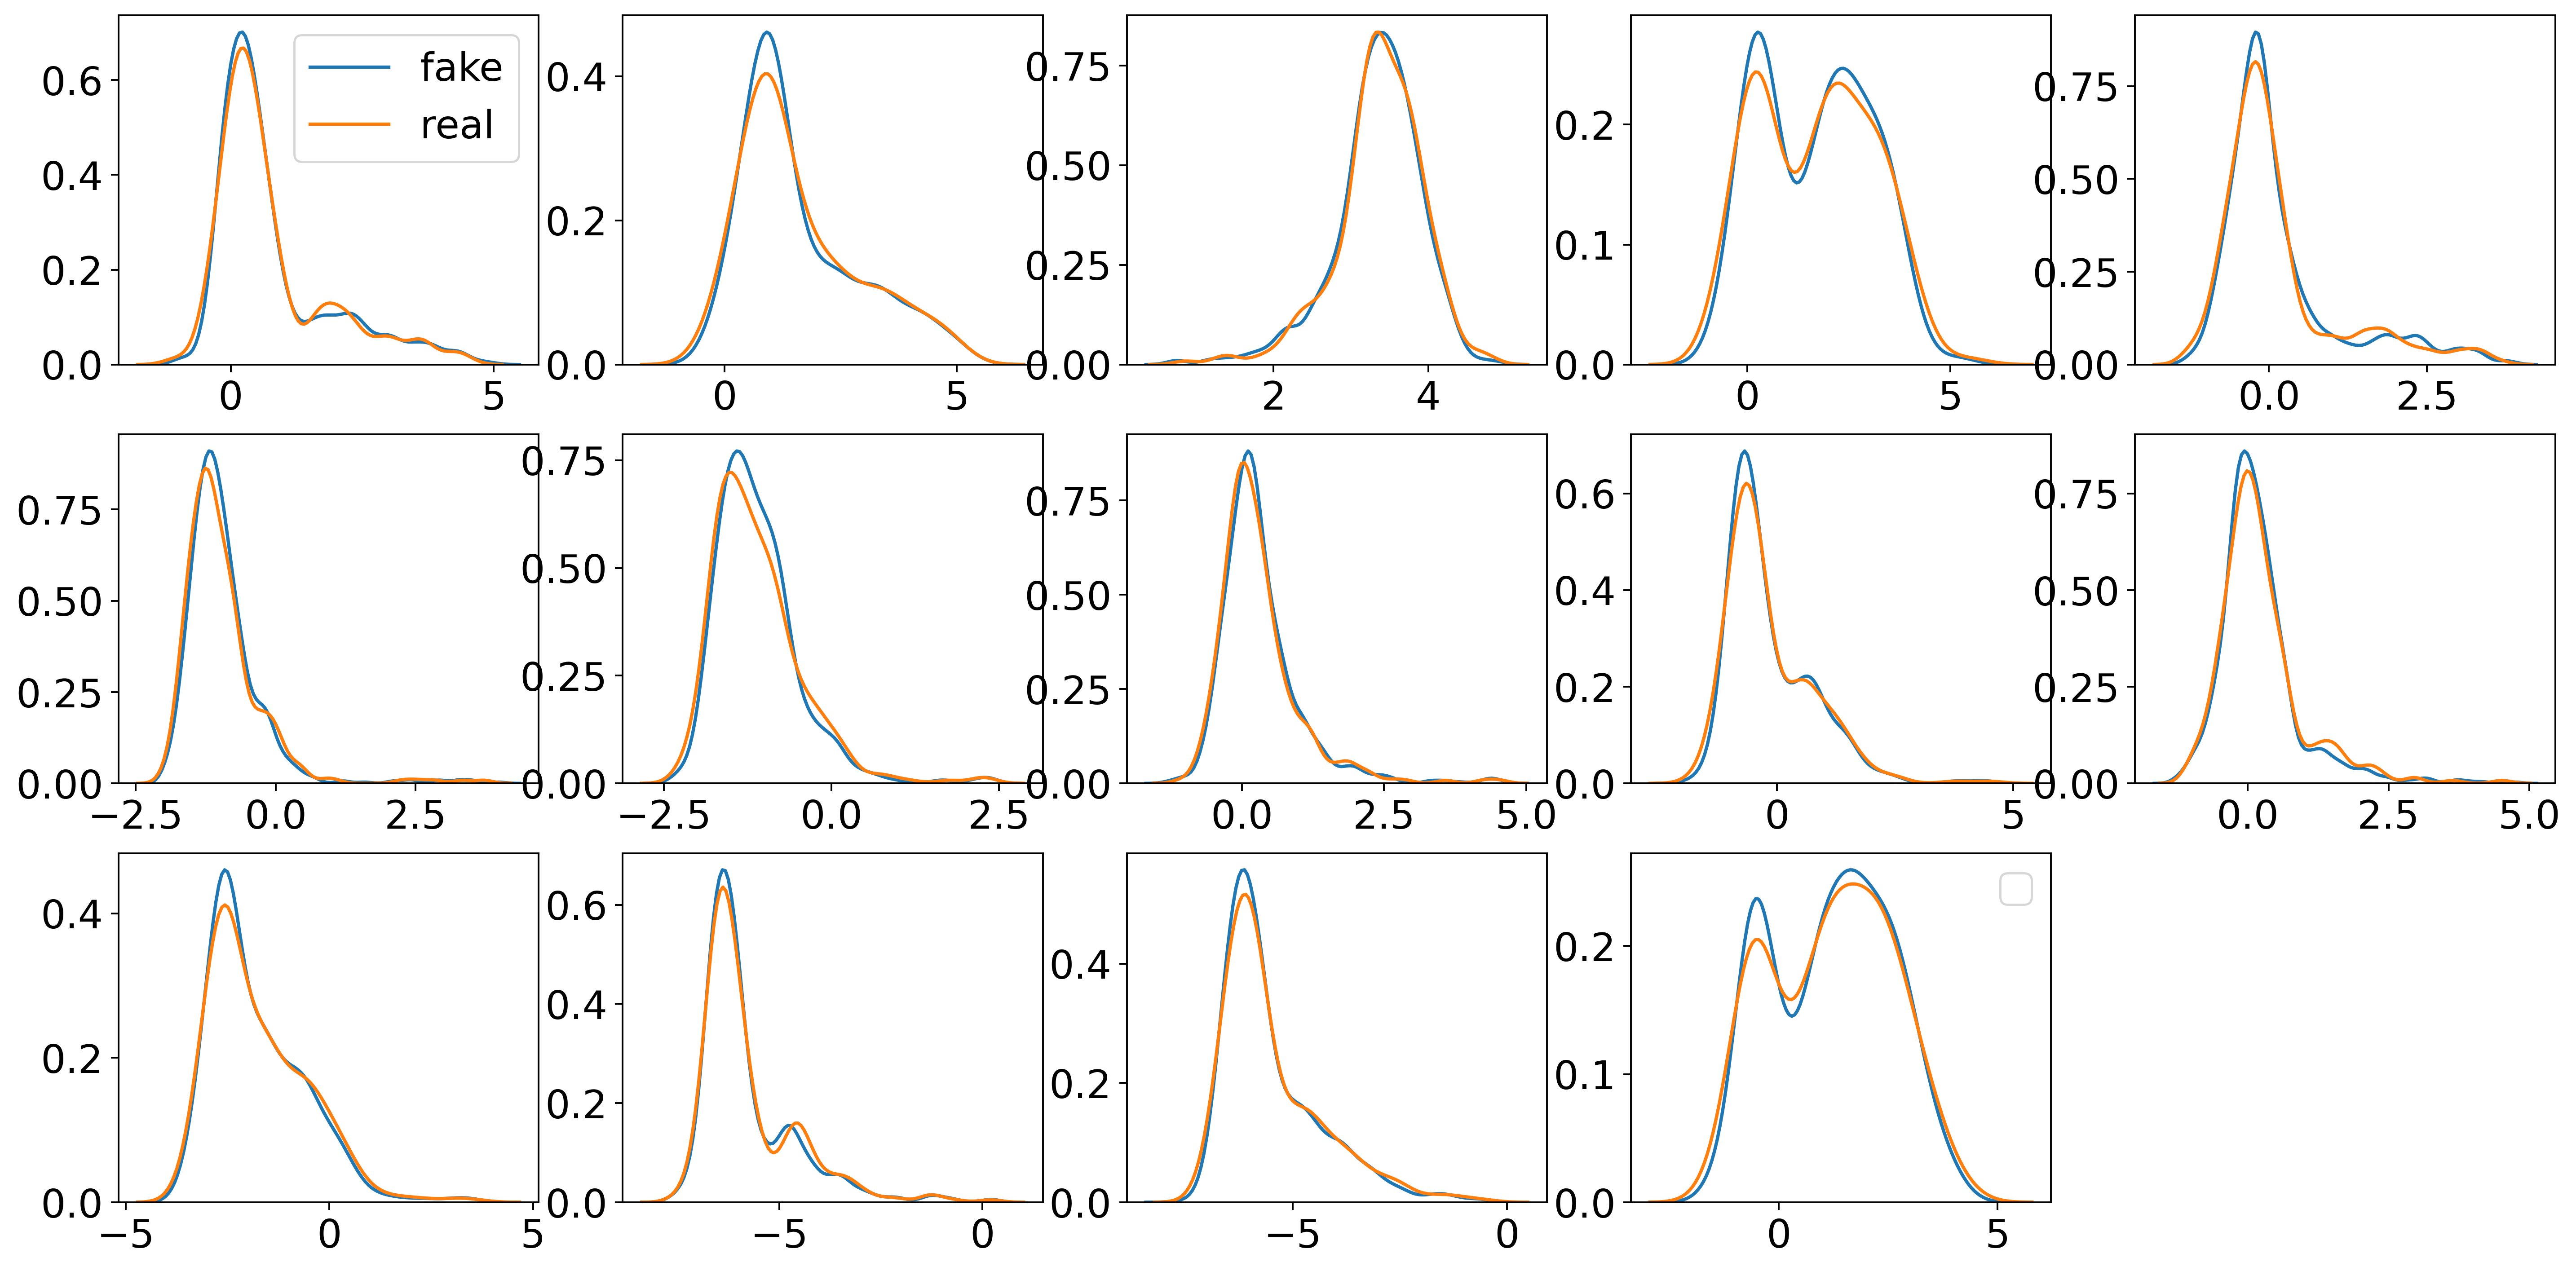

In [8]:
plt.figure(figsize=(20,10),dpi=350)
plt.subplot(3,5,1)
sns.kdeplot(G2[:,0],label="fake")
sns.kdeplot(T2[:,0],label="real")

for i in range(1,14):
    plt.subplot(3,5,i+1)
    sns.kdeplot(G2[:,i])
    sns.kdeplot(T2[:,i])
    

plt.legend()

No handles with labels found to put in legend.


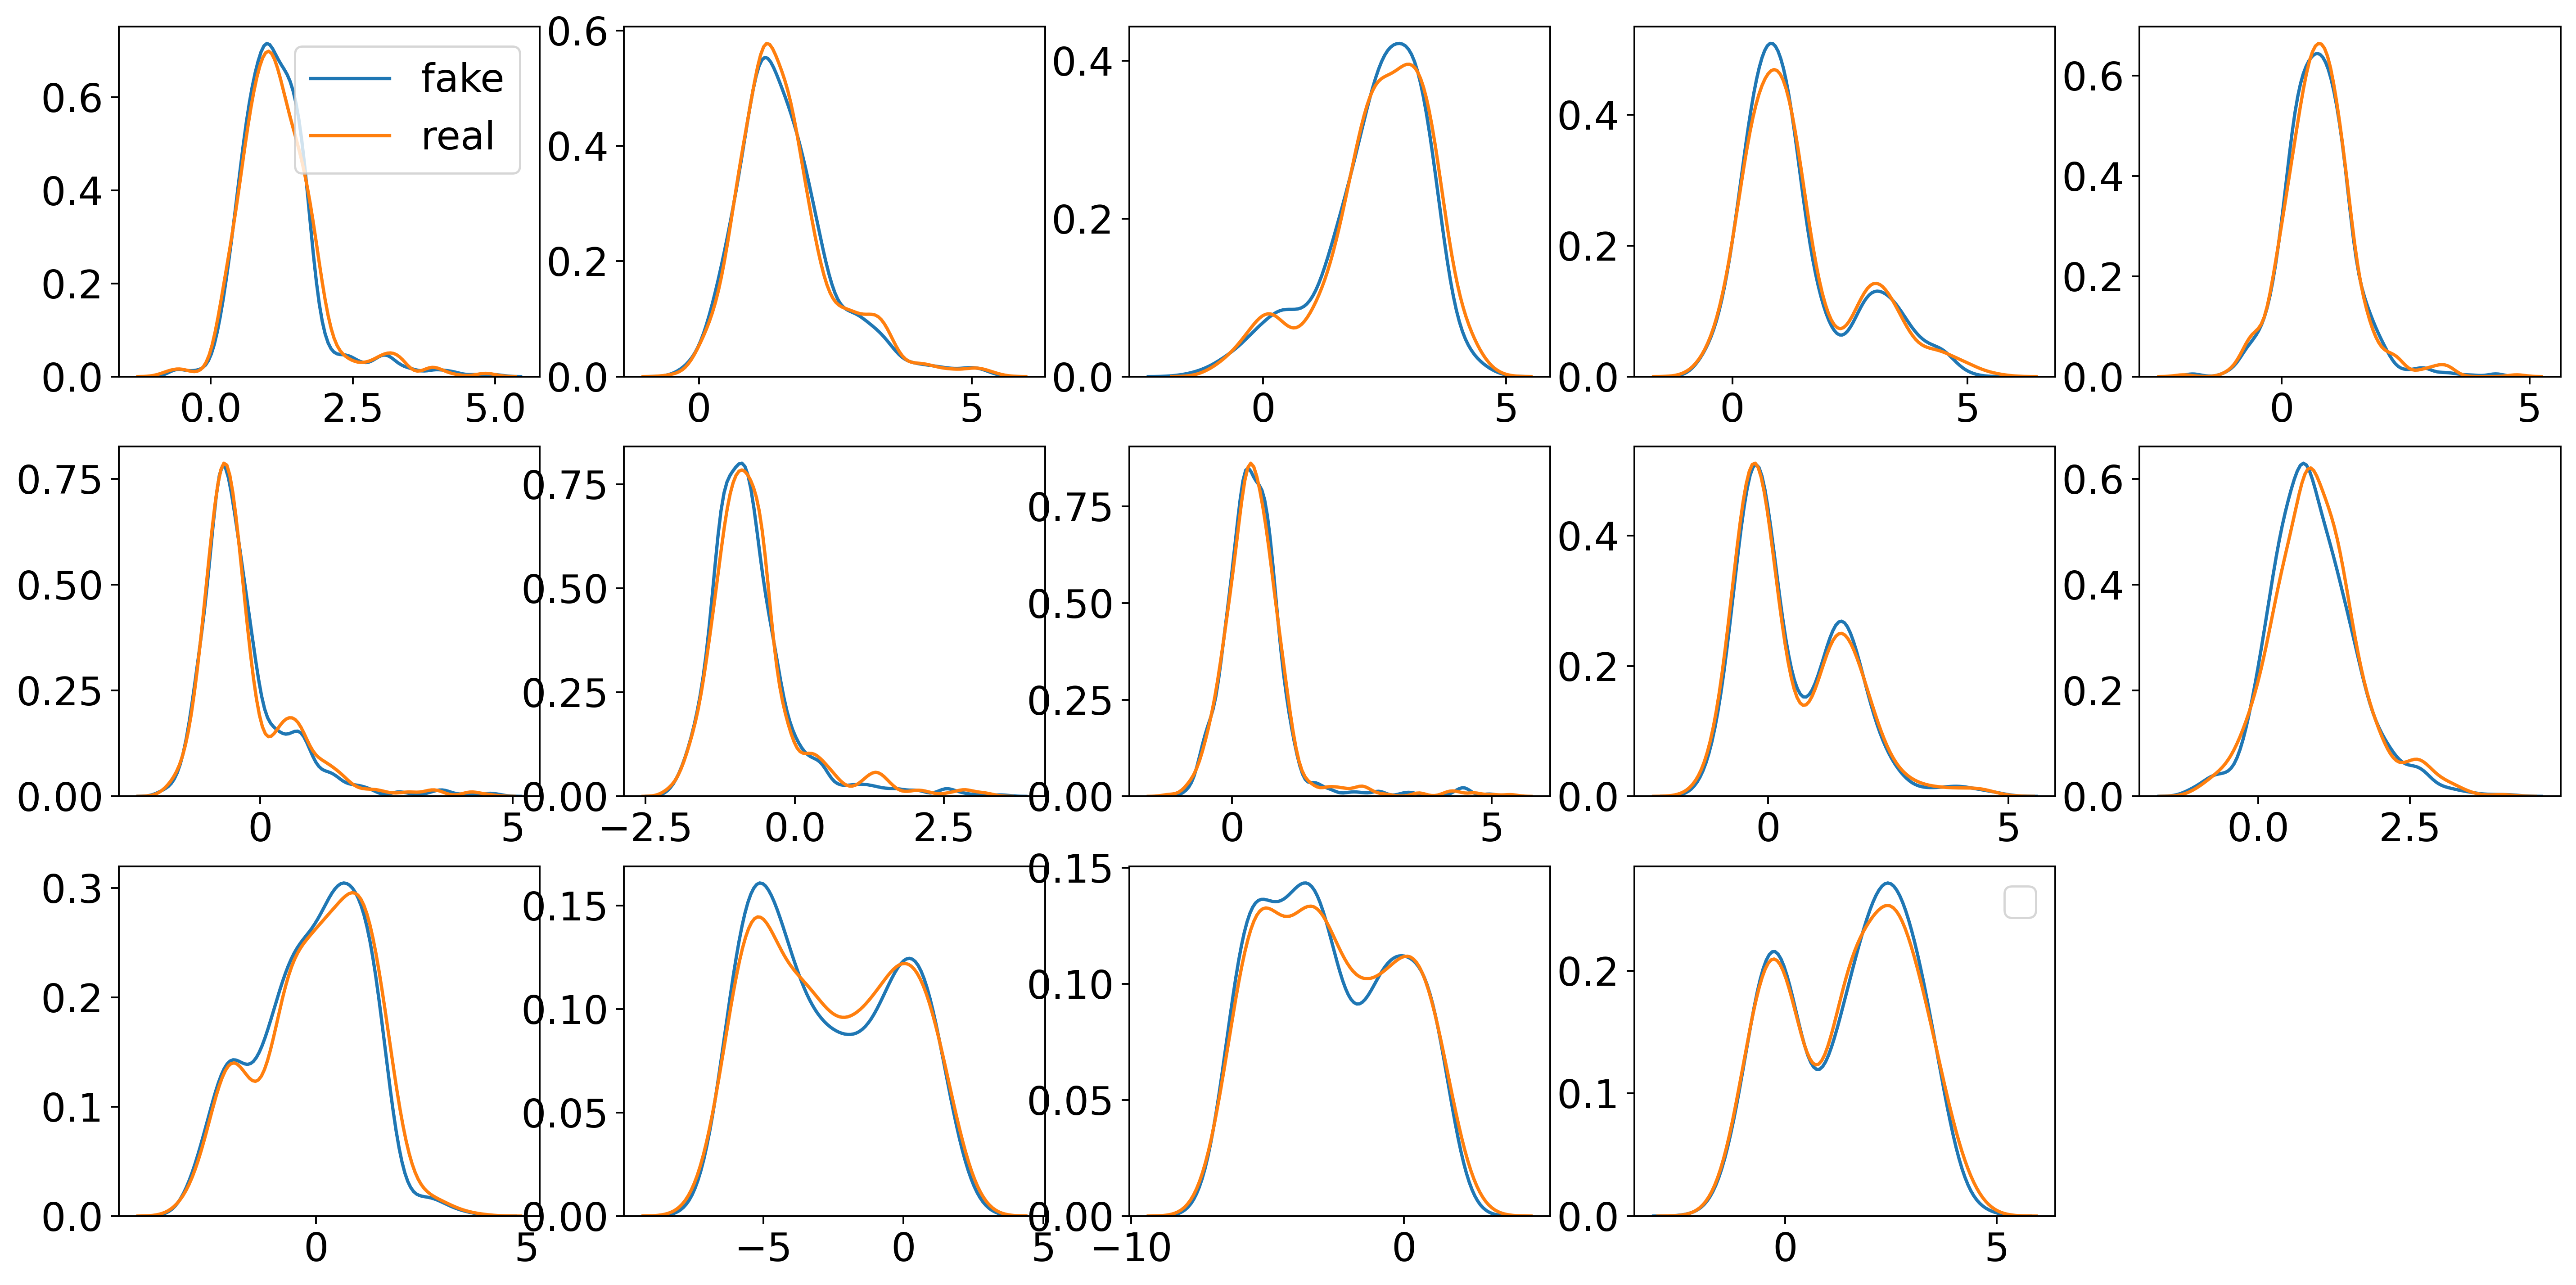

In [9]:
plt.figure(figsize=(20,10),dpi=350)
plt.subplot(3,5,1)
sns.kdeplot(G4[:,0],label="fake")
sns.kdeplot(T4[:,0],label="real")

for i in range(1,14):
    plt.subplot(3,5,i+1)
    sns.kdeplot(G4[:,i])
    sns.kdeplot(T4[:,i])

plt.legend()

No handles with labels found to put in legend.


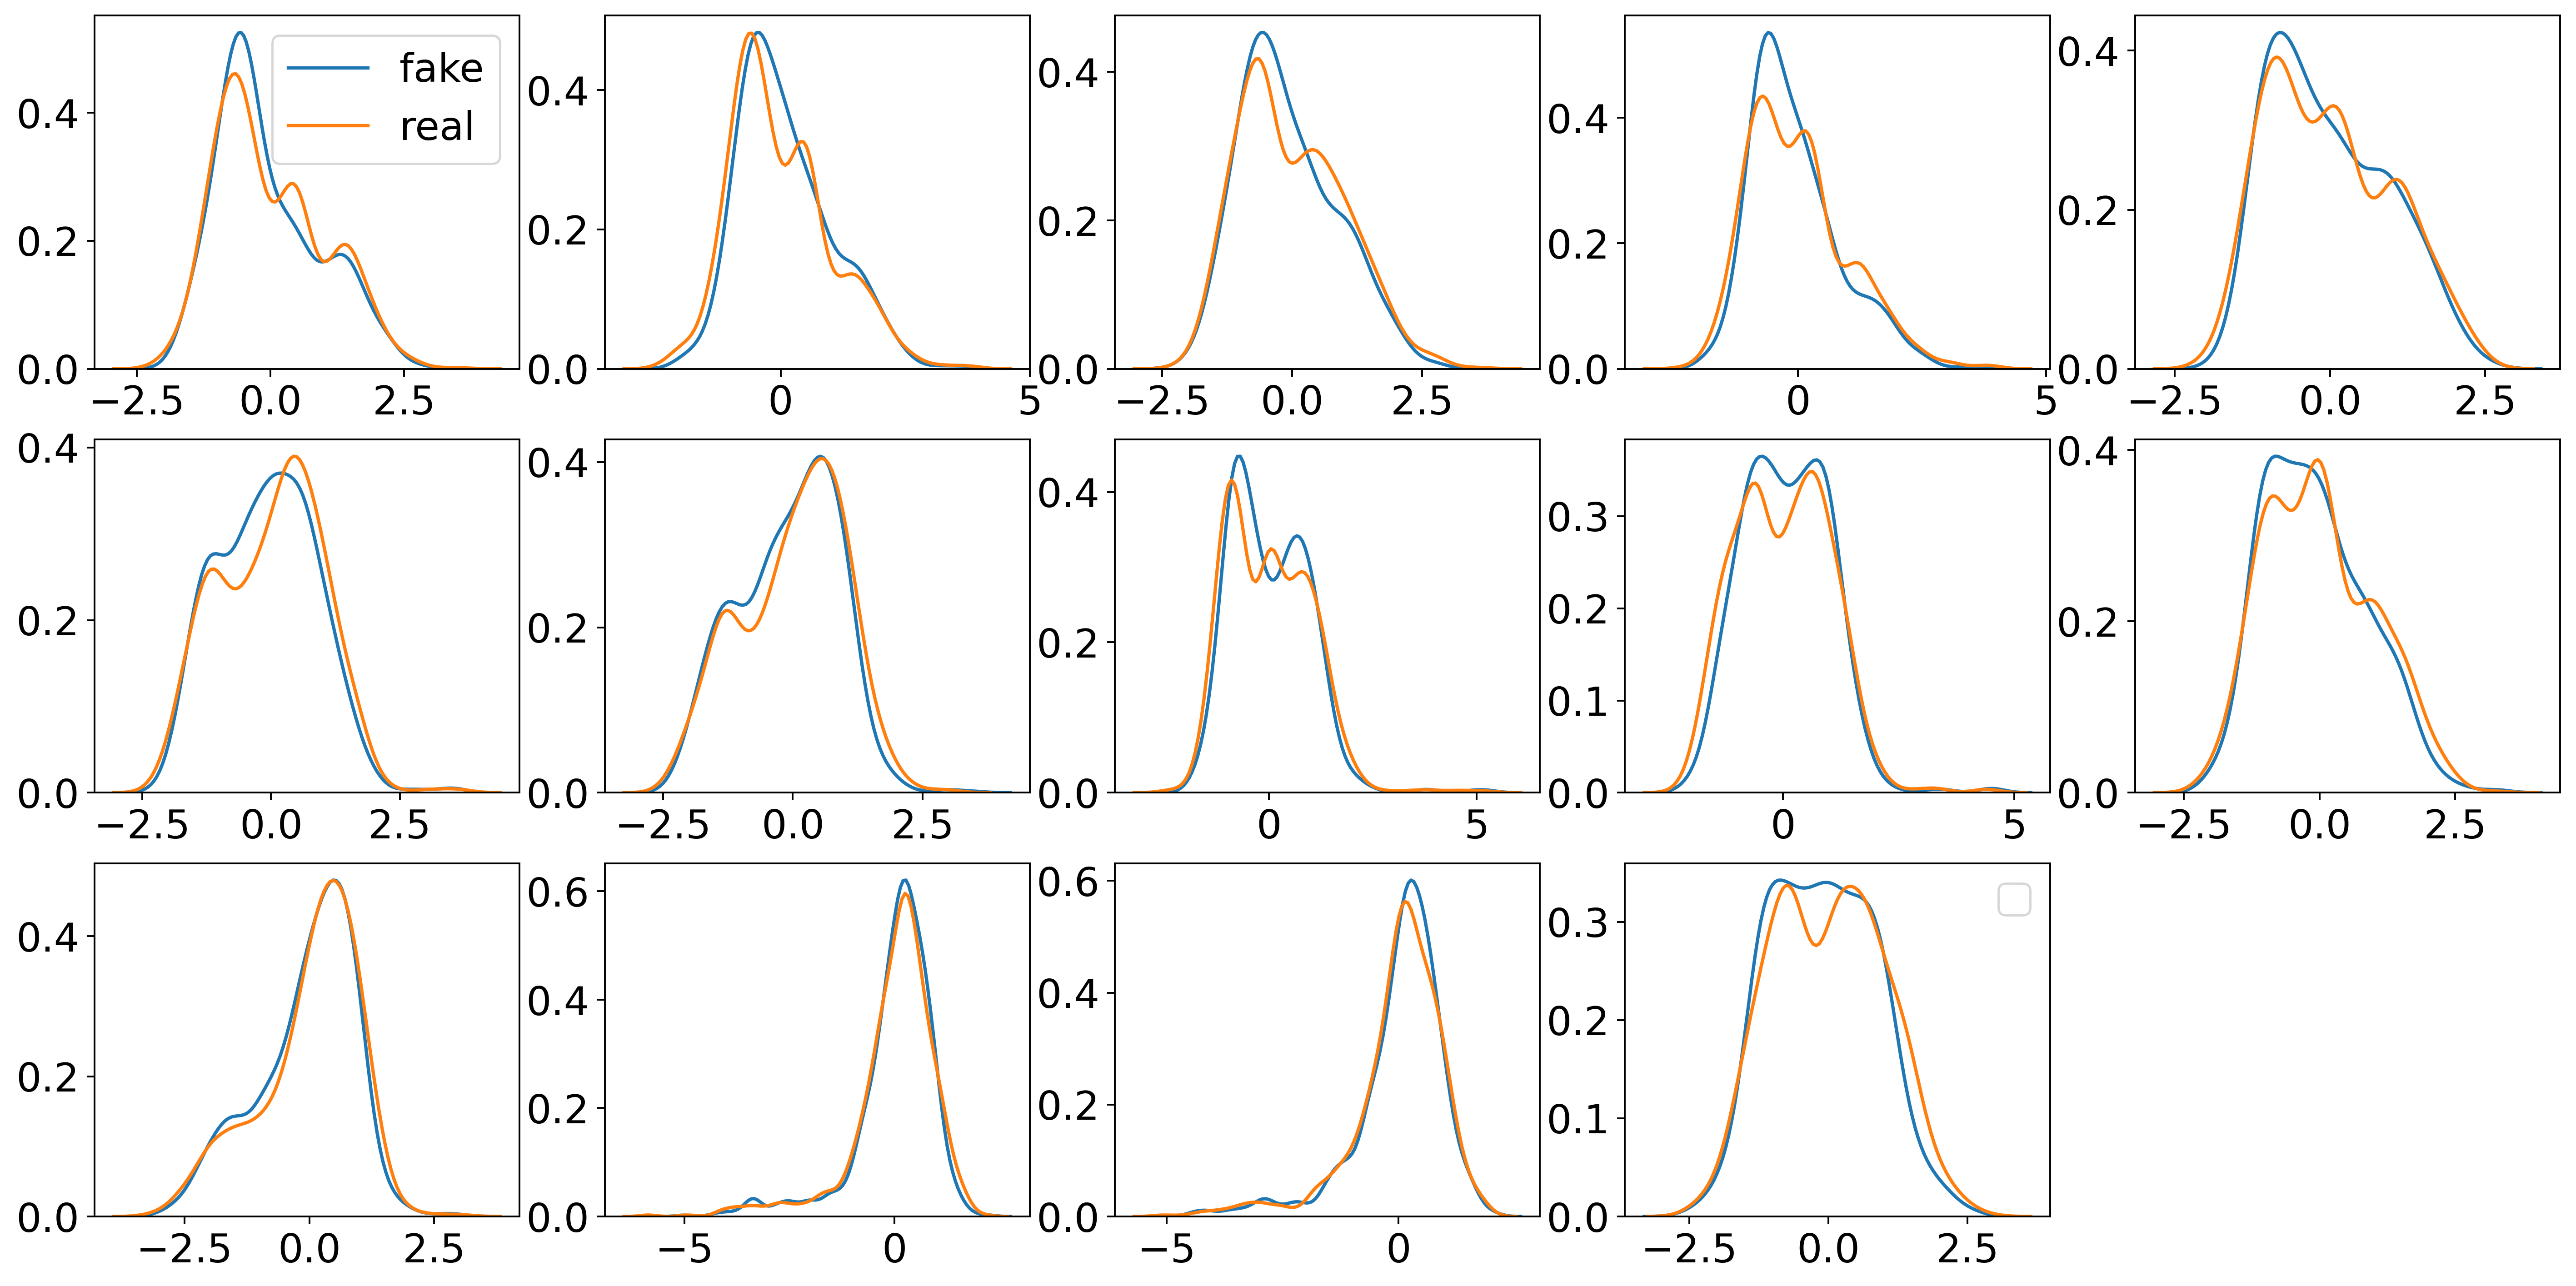

In [10]:
plt.figure(figsize=(20,10),dpi=350)
plt.subplot(3,5,1)
sns.kdeplot(G7[:,0],label="fake")
sns.kdeplot(T7[:,0],label="real")

for i in range(1,14):
    plt.subplot(3,5,i+1)
    sns.kdeplot(G7[:,i])
    sns.kdeplot(T7[:,i])
    

plt.legend()

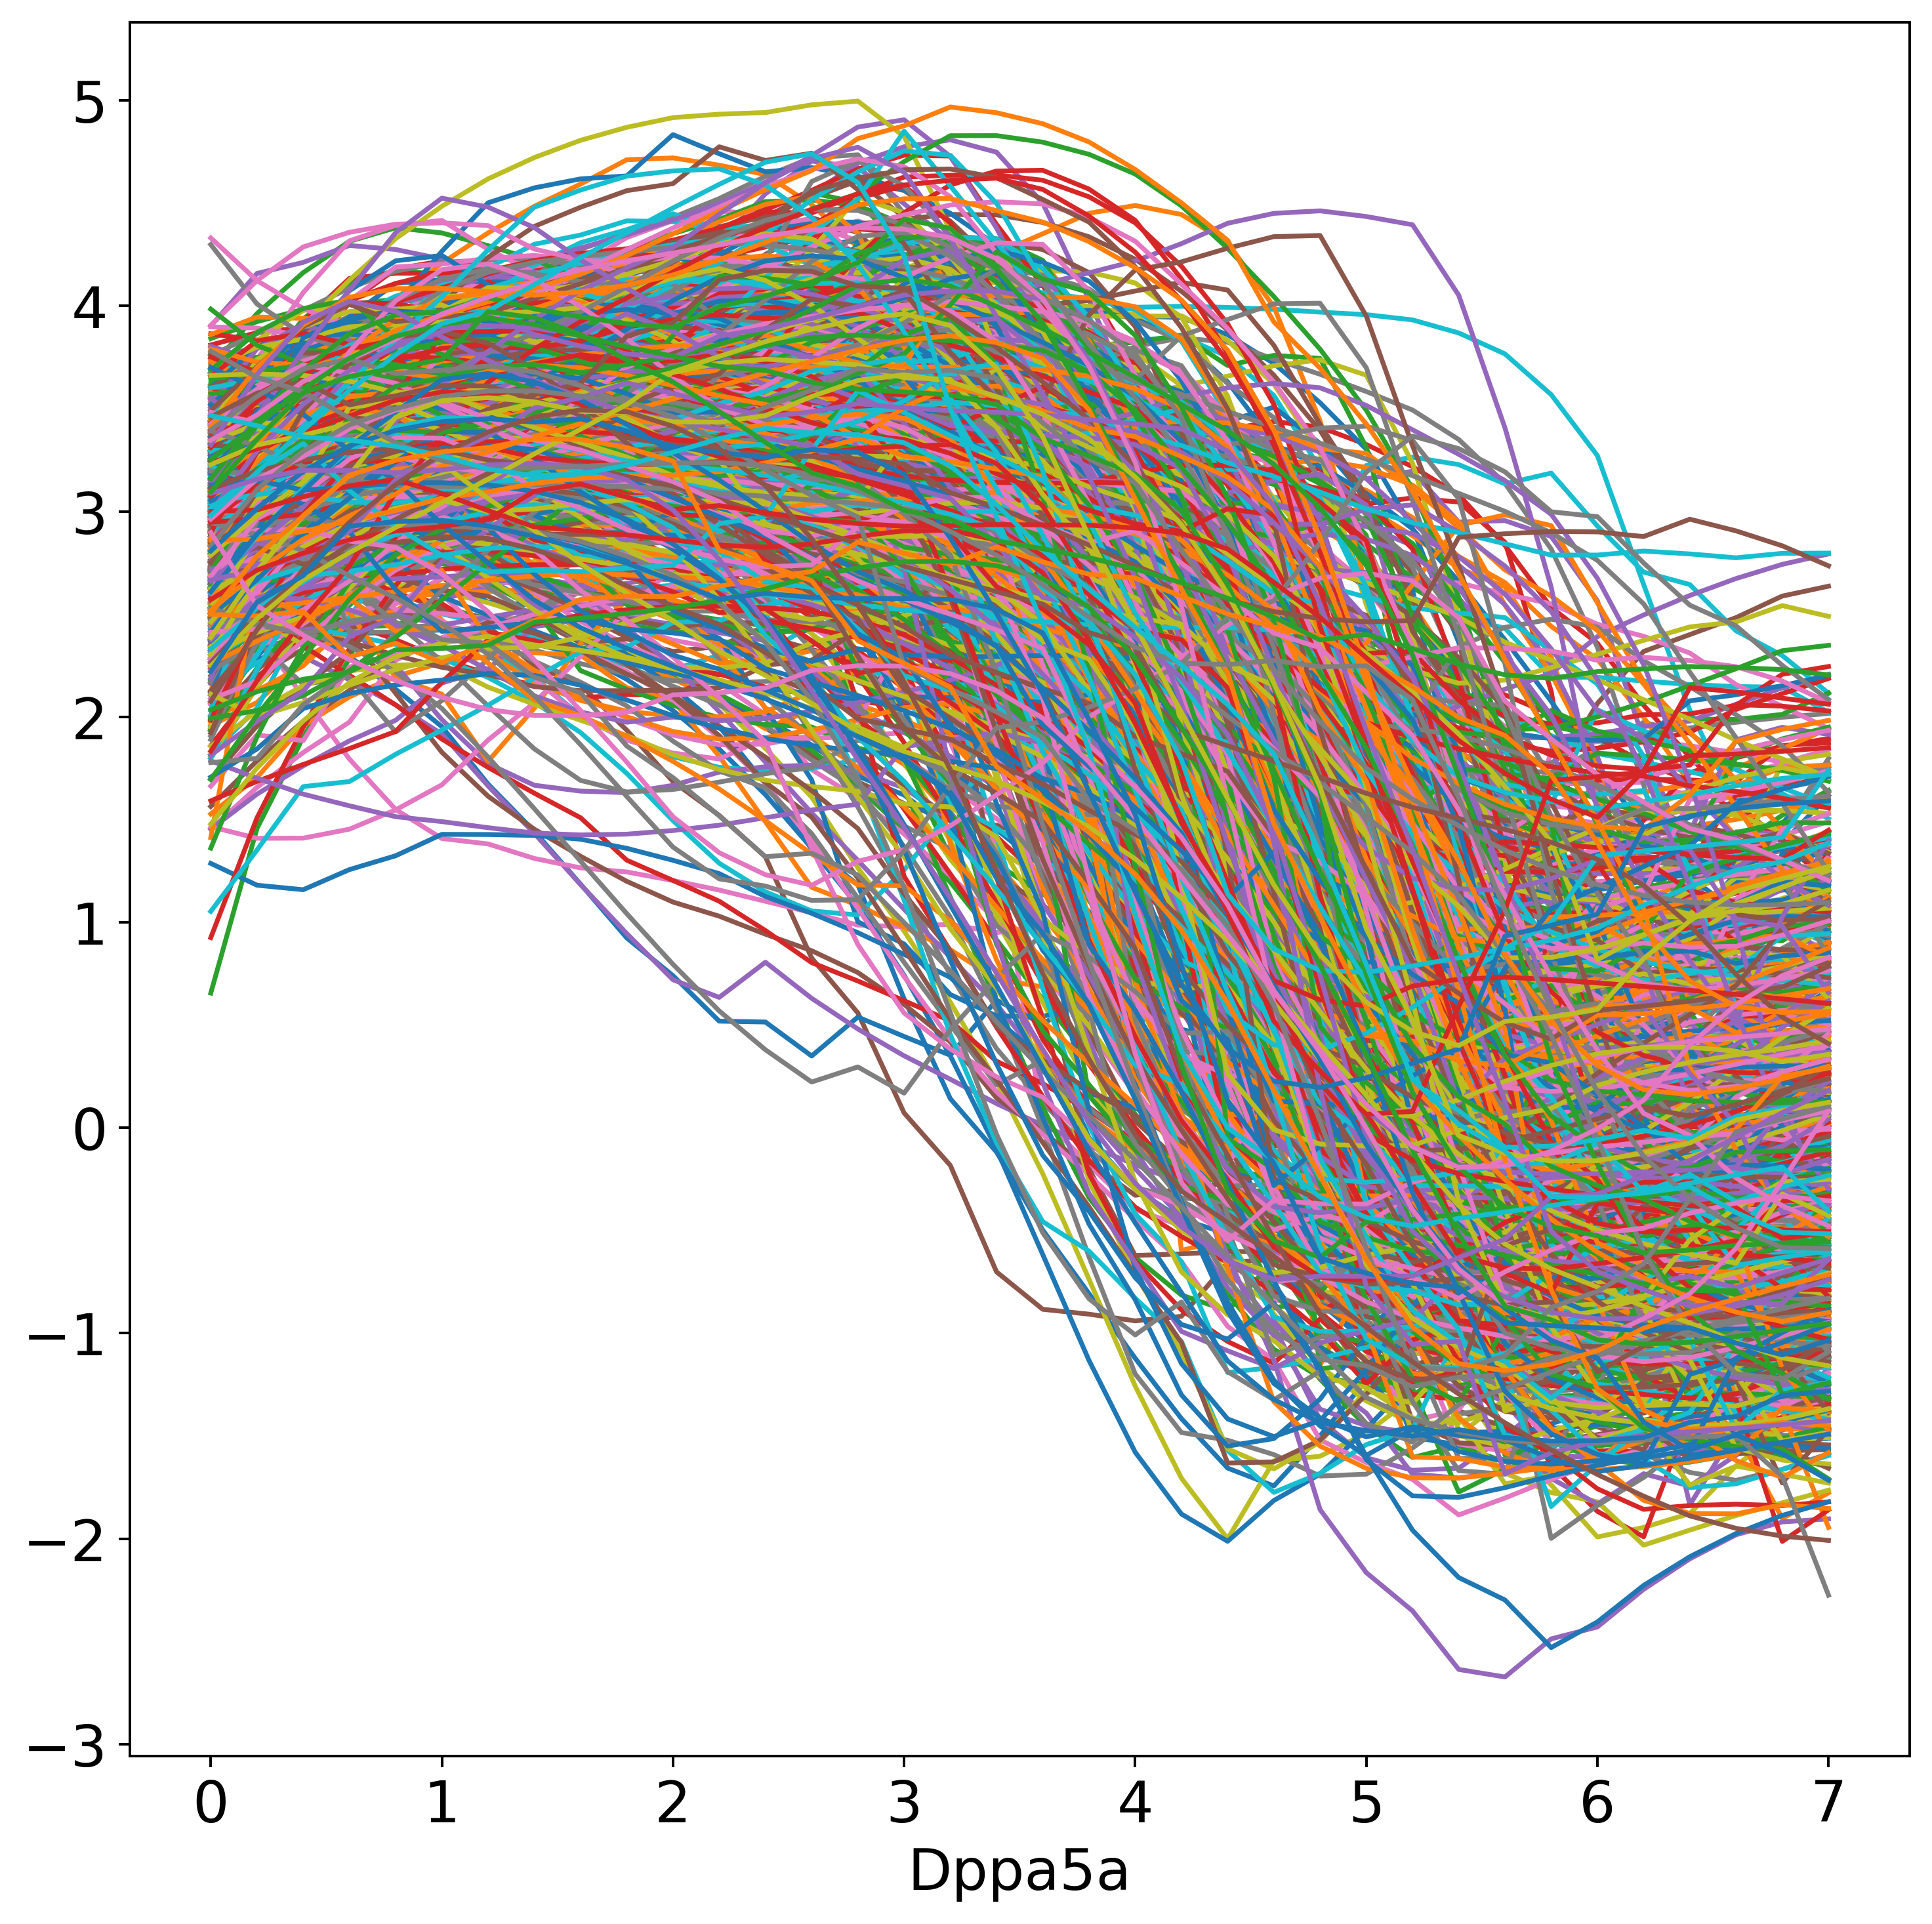

In [11]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,10),dpi=350)
for i in range(933):
    array = path[i,:,2].detach().cpu().numpy()
    plt.plot(np.linspace(0,7,num=36),array)
    
plt.xlabel("Dppa5a")

plt.savefig("gene14Dppa5a.jpg",format="jpg")